# Angle Exercise
This is the supplementary Python code for the Exercise 5.5 in "Simo Sarkka (2013), Bayesian Filtering and Smoothing". <br>
The exercise consists in completing the function:
- `ekf_update`

```python

def ekf_update(x, cov, obs): 
    """ Update the state belief based on prior belief and new observation
    """
    # Do something
    return updated_x, updated_cov

```

## Standard imports

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
import scipy.stats as st

## Utility functions

In [6]:
def mv_normal(m, C):
    """ Samples a multivariate normal of mean m and covariance C
    Example:
    >>> m = np.array([0., 0.])
    >>> C = np.eye(2)
    >>> mv_normal(m, C).size
    2
    """
    sample = np.random.randn(*m.shape)
    return m + np.linalg.cholesky(C) @ sample

In [7]:
def rmse(x, y):
    """ Root mean square error between two vectors x and y
    Example:
    >>> x = np.ones(10)
    >>> y = np.ones(10) * 0.5
    >>> rmse(x, y)
    0.5
    """
    return np.sqrt(np.mean(np.square(x-y)))

In [8]:
def filter_routine(initial_guess, initial_guess_covariance, update_method, observations):
    """ Loops over the observations and calls the implemented update_method
    Example:
    >>> initial_guess = np.array([0, 0])
    >>> initial_covariance = np.eye(2)
    >>> def update_method(x, cov, obs): return x, cov
    >>> observations = np.random.randn(500)
    >>> states, state_covariances = filter_routine(initial_guess, initial_covariance, update_method, observations)
    >>> shape_ok = states.shape[0] == state_covariances.shape[0] == observations.shape[0]
    >>> values_ok = np.all(states == 0)
    >>> values_ok and shape_ok
    True
    """
    T = observations.shape[0]
    x = initial_guess[:]
    cov = initial_guess_covariance[:]
    
    states = np.empty((T, *x.shape))
    covariances = np.empty((T, *initial_guess_covariance.shape))
    
    for i, y in enumerate(observations):
        x, cov = update_method(x, cov, y)
        states[i, :] = x
        covariances[i, :] = cov
    
    return states, covariances
    

In [9]:
def plot_results(filtered_states, true_states, observations, title, filtered_covariances=None):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 10), sharex=True)
    
    T = observations.shape[0]
    
    axes[0].plot(filtered_states[:, 0], label="Estimated signal", color="b")
    axes[0].plot(true_states[:, 0], label="True signal", linestyle='--', color="r")
    axes[0].scatter(np.arange(T), observations, marker="o", color="g", label="Measurements")    
    
    axes[1].plot(filtered_states[:, 1], label="Estimated derivative", color="b")
    axes[1].plot(true_states[:, 1], label="True derivative", linestyle='--', color="r")
    
    error = rmse(filtered_states, true_states)
    
    for ax in axes.flatten():
        ax.legend(loc="upper left")
    
    if filtered_covariances is not None:
        axes[0].fill_between(np.arange(T), 
                             filtered_states[:, 0] - filtered_covariances[:, 0, 0],
                             filtered_states[:, 0] + filtered_covariances[:, 0, 0],
                             alpha=0.33, 
                             color="b")
        axes[1].fill_between(np.arange(T), 
                             filtered_states[:, 1] - filtered_covariances[:, 1, 1],
                             filtered_states[:, 1] + filtered_covariances[:, 1, 1],
                             alpha=0.33, 
                             color="b")
        fig.suptitle(f"{title} and confidence intervals - RMSE: {error:.3f}")
    else:
        fig.suptitle(f"{title} - RMSE = {error:.3f}")


## Get data

We consider a bearings only target tracking problem on the location and velocity of an object evolving on a 2D plane: $\mathbf{z_t}=\left(x_t, y_t, \dot x_t, \dot y_t \right)^T$ where the dynamics are given by the discretized Weiner velocity model $\mathbf{z_t} = A \mathbf{z_{t-1}} + \mathcal{N}(0, Q)$ and the measurements are given by the angle respective to two static sensors $\mathbf{s^i} = (s^i_x, s^i_y)^T$: $\theta^i_t = \tan^{-1}{\left(\frac{y_t - s^i_y}{x_t-s^i_x}\right)} + \mathcal{N}(0, \sigma^2)$


where we have $
A = \left(\begin{matrix} 1 & 0 & \delta t & 0 \\ 
                         0 & 1 & 0 & \delta t \\
                         0 & 0 & 1 & 0 \\
                         0 & 0 & 0 & 1
          \end{matrix}
    \right), 
\quad 
Q = q \left(\begin{matrix}
                \frac{\delta t^3}{3} & 0 & \frac{\delta t^2}{2} & 0 \\
                0 & \frac{\delta t^3}{3} & 0 & \frac{\delta t^2}{2} \\
                \frac{\delta t^2}{2} & 0 & \delta t & 0 \\
                0 & \frac{\delta t^2}{2} & 0 & \delta t
        \end{matrix}\right)$


For the remainder of the notebook, we will take: 
- $\sigma = 0.05$
- $\delta t = 0.01$
- $q = 0.1$
- $\mathbf{s^1} = \left(\begin{matrix} -1.5 \\ 0.5 \end{matrix}\right), \quad \mathbf{s^2} = \left(\begin{matrix} 1 \\ 1 \end{matrix}\right)$

In [330]:
random_state = np.random.RandomState(31415926)

In [362]:
sigma = 0.05
dt = 0.01
r = 0.1

In [363]:
z_0 = np.array([0., 0., 1., 0.])

In [377]:
s_1 = np.array([-1.5, 0.5])
s_2 = np.array([1., 1.])
sensors = np.stack([s_1, s_2])

In [378]:
def generate_trajectory_and_measurements(z_0, s, dt, sigma, steps, random_state):
    """ Creates a smooth curvy trajectory and samples the noisy measured angles.

    Parameters
    ----------
    z_0 : (4,) array_like
        Initial position and velocity
    s : (2, 2) array_like
        Location of sensors (s1 = s[0, :], s2 = s[1, :])
    dt : float
        Time between each measurement
    sigma : float
        Observation standard deviation
    steps : int
        Number of steps simulated
    random_state : RandomState
        Random state used for pseudo-random numbers generation
        
    Returns
    -------
    timeline: (steps) ndarray
        The observation times
    states : (steps, 4) ndarray
        The true states
    thetas : (steps, 2) ndarray
        The noisy angles
    """
    
    a = np.zeros(steps)
    a[steps // 10: 2 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    a[4 * steps // 10: 5 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    a[7 * steps // 10: 8 * steps // 10] = np.pi/2/51/dt + 0.01 * random_state.randn(steps // 10)
    
    z = z_0[:]
    
    states = np.empty((steps, 4))
    thetas = np.empty((steps, 2))
    
    for i in range(steps):
        F = np.array([[0, 0, 1, 0], 
                      [0, 0, 0, 1], 
                      [0, 0, 0, a[i]],
                      [0, 0, -a[i], 0]])

        expF = lin.expm(F * dt)
        z = expF @ z
        states[i, :] = z
        thetas[i, 0] = np.arctan2(z[1] - s[0, 1], z[0] - s[0, 0]) + sigma * random_state.randn()
        thetas[i, 1] = np.arctan2(z[1] - s[1, 1], z[0] - s[1, 0]) + sigma * random_state.randn()

    return np.arange(dt, (steps + 1) * dt, dt), states, thetas

In [379]:
steps = 500

timeline, true_states, thetas = generate_trajectory_and_measurements(z_0, sensors, dt, sigma, steps, random_state)

In [380]:
def inverse_bearings(s, thetas):
    """We use the fact that tan(\theta_i) Z_y - Z_x = tan(\theta_i) S^i_y - S^i_x
    where Z is the coordinates corresponding to the measured angles to build a system of 
    linear equations in the coordinates"""
    
    tan_theta = np.tan(thetas)
    ones =  np.ones_like(thetas)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("ijk,jk->ij", matrices, s)
    return np.linalg.solve(matrices, target_vectors)
    

In [381]:
def plot_bearings(true_states, thetas, s):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    observed_positions = inverse_bearings(s, thetas)
    
    ax.plot(*true_states[:, :2].T, linestyle='--', label="True Signal")
    ax.quiver(*true_states[::10].T, units='xy' ,scale=5, width=0.01, label="Velocity every 20 steps")
    ax.scatter(*true_states[0, :2], marker="*", s=200, label="Starting point", color='orange')
    ax.scatter(*observed_positions.T, marker="o", facecolors='none', s=10, label="Observations", color='red')
    ax.scatter(*s[0], marker="o", s=200, label="Sensor 1", color='k')
    ax.scatter(*s[1], marker="x", s=200, label="Sensor 2", color='k')
    
    ax.set_xlabel("Time step")
    ax.set_aspect('equal', adjustable='box')
    ax.legend(loc="lower left")
    fig.suptitle("Simulated data")

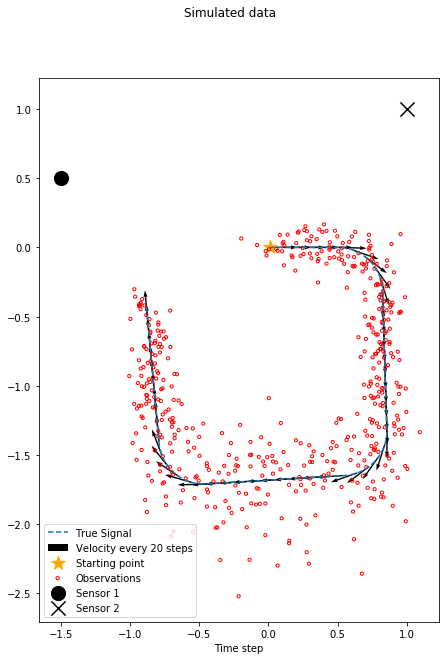

In [382]:
plot_bearings(true_states, thetas, sensors)

## Set up the model

- Transition matrix:

In [383]:
A = np.array([[1, 0, dt, 0], 
              [0, 1, 0, dt], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]])

- Parameter for the process noise covariance matrix

In [384]:
q = 0.1

- Process noise covariance matrix

In [385]:
Q = q * np.array([[dt ** 3 / 3, 0, dt ** 2 / 2, 0], 
                  [0, dt ** 2 / 2, 0, dt ** 3 / 3], 
                  [dt ** 2 / 2, 0, dt, 0],
                  [0, dt ** 2 / 2, 0, dt]])

## Initial Guess

We initialize to the true value with some uncertainty:

In [386]:
initial_state = true_states[0]
initial_covariance = np.eye(4)

In [413]:
def plot_results(true_states, approx_states, name, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    
    ax.plot(*true_states[:, :2].T, linestyle='--', label="True Signal")
    ax.plot(*approx_states[:, :2].T, linestyle='--', label=name)
    ax.scatter(*true_states[0, :2], marker="*", s=200, label="Starting point", color='orange')
    
    ax.set_xlabel("Time step")
    ax.legend(loc="upper left")
    fig.suptitle(title, y=0.95, fontsize=15)

## Baseline solution

We provide a baseline solution where the state is simply the inverse of the bearing measurement.

In [414]:
def baseline_update_method(x, cov, theta):
    """ A baseline method that inverts the bearings measurement: 
    we use a local function similar to inverse_bearings defined above.
    Example:
    >>> x = np.array([0.15, 0., 1., 1.])
    >>> cov = np.eye(4)
    >>> theta = np.array([np.atan(1), -np.atan(1)])
    >>> sensors = np.array([[-1., 0.], 
    ...                     [1., 0.]])
    >>> new_x, new_cov = baseline_update_method(x, cov, obs)
    >>> np.allclose(new_x, [0., -1., 0., 0.])
    True
    """
    tan_theta = np.tan(theta)
    ones =  np.ones_like(theta)
    matrices = np.stack([tan_theta, -ones], axis=-1)
    target_vectors = np.einsum("jk,jk->j", matrices, sensors)
    res = np.linalg.solve(matrices, target_vectors)
    return np.concatenate([res, np.zeros_like(res)]), cov


In [415]:
baseline_states, _ = filter_routine(initial_state, initial_covariance, baseline_update_method, thetas)

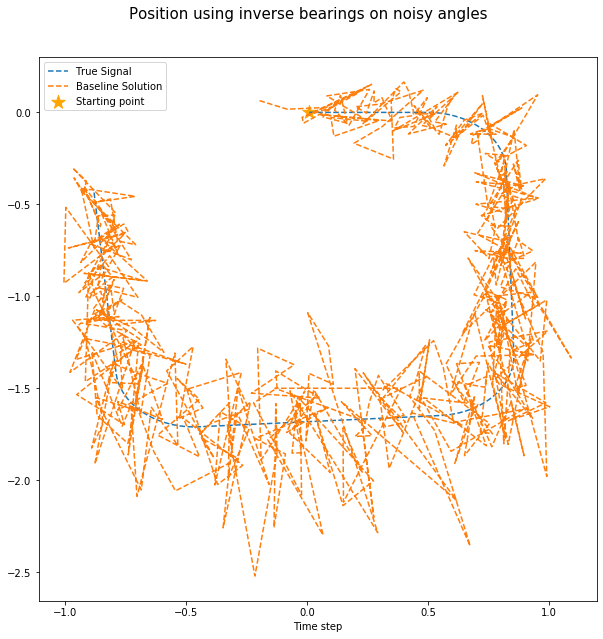

In [416]:
plot_results(true_states, baseline_states, "Baseline Solution", "Position using inverse bearings on noisy angles")

## Extended Kalman Filter

In [418]:
def extended_kalman_update(x, cov, theta):
    """ Implements the kalman equations as given in "Simo Sarkka (2013), Bayesian Filtering and Smoothing", Ch.5.
    Uses the global variables A, Q, sigma, sensors
    """
    # You should replace the below equations
    new_x = x
    new_cov = cov
    return new_x, new_cov

In [420]:
ek_states, ek_covariances = filter_routine(initial_state, initial_covariance, extended_kalman_update, thetas)

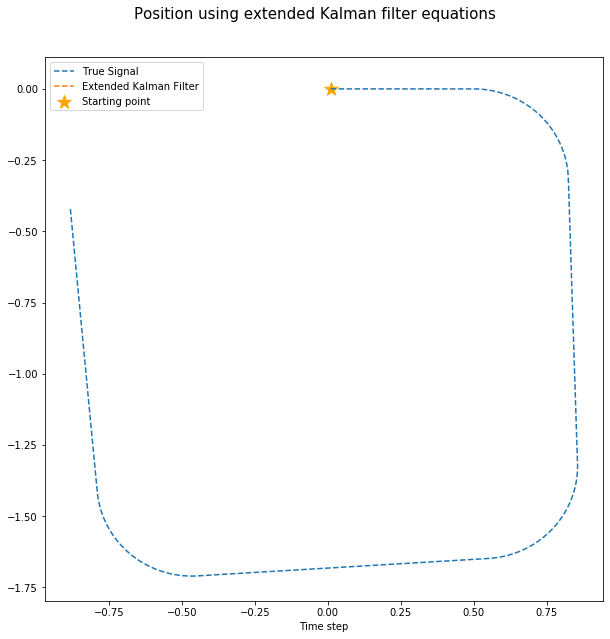

In [421]:
plot_results(true_states, ek_states, "Extended Kalman Filter", "Position using extended Kalman filter equations")